# Movie script analysis

![Poster](https://i2.wp.com/uozzart.com/wp-content/uploads/2020/03/Harry-Potter..jpg?resize=768%2C492&ssl=1)

<div class="alert alert-success">

In this notebook I'm going to analyze the scripts of 90 movies and see what we can learn about the characters and the movies just by looking at the dialogs between characters. 

It's been mainstream to classify movies based on the summary of the plot, but can we guess the genre and cluster movies from the scripts only? Can we infer topics which are present in one movie but less so in the other? Which characters appear to be similar to each other? These are types of questions I am willing to find answers to.
</div> 

## Load data

### Import libraries

In [126]:
import spacy
import string
import pandas as pd
import numpy as np
import os
import re
import warnings
warnings.filterwarnings('ignore')

from nltk.corpus import stopwords
from collections import defaultdict,Counter

nlp = spacy.load('en_core_web_sm')
stopwords_ = set(stopwords.words('english'))

# For topic modeling
from gensim.models import AuthorTopicModel, LdaMulticore, TfidfModel, CoherenceModel, Word2Vec, Doc2Vec
from gensim.corpora import Dictionary
from gensim.models.phrases import Phrases
from gensim.models.word2vec import FAST_VERSION
from gensim.models.doc2vec import TaggedDocument
import multiprocessing


%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.cm as cm
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# For latent dimensions and clustering 
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD, NMF 
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

### Get data

In [ ]:
prefixed = [filename for filename in os.listdir(os.getcwd()+'/scripts')]
str(prefixed[1])

all_scripts = pd.DataFrame()

for file in prefixed:
    script = pd.DataFrame()
    documents = pd.Series([line.strip() for line in open(os.getcwd()+'/scripts/'+str(file), encoding='unicode_escape').readlines()])
    script['script'] = documents
    script['movie'] = pd.Series([file]*len(documents))
    all_scripts = all_scripts.append(script, ignore_index=True)

Dataset is a [Cornell Movie-Dialogs Corpus](https://www.cs.cornell.edu/~cristian/memorability.html). The original dataset came in the form of multiple documents each containing a script of a film, so first steps were to create a dataframe comfortable to work with.  

<div class="alert alert-warning">
    
**BEFORE**
    
</div>

![](https://i.postimg.cc/tRP3Cfmy/script.png)

<div class="alert alert-success">

**AFTER**
    
 </div>

In [22]:
print(all_scripts.shape)
all_scripts.head()

(73882, 2)


,script,movie
0,WATSON: The year was 1891. London was the capi...,Sherlock-Holmes.dial
1,"WATSON: I had come to London, ten years prior,...",Sherlock-Holmes.dial
2,WATSON: And that had everything to do with one...,Sherlock-Holmes.dial
3,WATSON: ... Sherlock Holmes.,Sherlock-Holmes.dial
4,:,Sherlock-Holmes.dial


## Data preprocessing

### Define functions

In [9]:
def clean_hard(text):
    return ' '.join([token.lemma_ 
            for token in nlp(text)
            if token.pos_ in {'NOUN', 'VERB', 'ADJ', 'ADV', 'X', 'PROPN'} 
                and len(token.text) > 2 and token.text not in stopwords_]) 

def preprocess_text(text):
    text = re.sub('[^a-zA-Zа-яА-Я1-9]+', ' ', text)
    text = re.sub(' +', ' ', text)
    return text.lower().strip()

def clean_light(text):
    return ' '.join([token.text 
            for token in nlp(text) 
            if token.pos_ in {'NOUN', 'VERB', 'ADJ', 'ADV', 'X', 'PROPN'}
            and len(token.text) > 2 and token.text not in stopwords_])

### Cleaning steps

There are several steps I take to preprocess the data before diving into analysis and modeling:
1. Extract characters' names from scripts into a new column
2. Filter scene descriptions
3. Delete too short utterances
4. Clean the scripts by keeping only the lemmas of the context words (nouns, verbs, adjectives, adverb, pronouns or any other unassigned part-of-speech) which are longer than 2 characters and are not in the list of stopwords
5. Filter names and some other entities from scripts

In [10]:
# One strange file kept appearing in the folder, so I had to delete it here

all_scripts[all_scripts['movie']=='.DS_Store'].index
all_scripts.drop(all_scripts[all_scripts['movie']=='.DS_Store'].index, inplace=True)

In [11]:
# extract characters' names from scripts into a new column

all_scripts['character'] = all_scripts['script'].apply(lambda text: text.split(':')[0])
all_scripts['script'] = all_scripts['script'].apply(lambda text: text.split(':')[1:])
all_scripts = all_scripts.explode('script')
all_scripts['script']= all_scripts['script'].apply(lambda x: str(x).strip())

In [12]:
# get rid of author words and scene descriptions

pattern = ['INT.', 'EXT.', 'LATER','SCREEN', 'CLOSET', 'SCENE', 'ANGLE', 'RETURN', 'CLOSE']
all_scripts['non_relevant'] = all_scripts['character'].apply(lambda x: bool(re.search(r'INT.|EXT.|LATER|SCREEN|CLOSET|SCENE|ANGLE|RETURN|CLOSE', x)))
all_scripts = all_scripts[all_scripts.non_relevant == False]                                                                             

In [ ]:
# drop short utterances 

all_scripts['movie'] = all_scripts['movie'].apply(lambda x: re.sub(r'.dial', '', x))
all_scripts['len_nlp_script'] = all_scripts['script'].apply(lambda x: len(nlp(x)))
all_scripts = all_scripts[all_scripts['len_nlp_script'] > 2]


In [ ]:
# clean the scripts in a 'hard' or agressive way

all_scripts['clean_hard_script'] = all_scripts['script'].apply(clean_hard)

In [23]:
# drop remaing short utterances after cleaning step

all_scripts['len_nlp_script'] = all_scripts['clean_hard_script'].apply(lambda x: len(nlp(x)))
all_scripts_cleaned = all_scripts[all_scripts['len_nlp_script'] > 2]
print(all_scripts_cleaned.shape)
all_scripts_cleaned.head()

(41442, 6)


,script,movie,character,non_relevant,len_nlp_script,clean_hard_script
0,The year was 1891. London was the capital of t...,Sherlock-Holmes,WATSON,False,18,year London capital world height modernity his...
1,"I had come to London, ten years prior, to find...",Sherlock-Holmes,WATSON,False,20,come London year prior find life afghan war ho...
2,And that had everything to do with one man. My...,Sherlock-Holmes,WATSON,False,4,man friend partner burden
3,"My apologies. Send the bill to John Watson, 22...",Sherlock-Holmes,HOLMES,False,8,apology send bill John Watson 221B Baker Street
4,"Head cocked to the left, partial deafness in r...",Sherlock-Holmes,HOLMES,False,10,Head cock left partial deafness right ear firs...


In [ ]:
documents = all_scripts_cleaned.script.tolist()

clean_ents = [[token.text for token in nlp(sentence).ents 
  if token.label_ in ['TIME','DATE','GRE','CARDINAL','MONEY','PERCENT','PERSON']] 
  for sentence in documents]

docs_no_names = []

for ents, sentence in zip(clean_ents, documents):
    for ent in ents:
        try:
            sentence = re.sub(re.compile(ent), '', str(sentence))
        except:
            print(sentence)
            pass
    docs_no_names.append(sentence)
    
print(len(docs_no_names))
docs_no_names[:3]

In [31]:
all_scripts_cleaned['script_no_names'] = docs_no_names
all_scripts_cleaned['script_no_names_cleaned'] = all_scripts_cleaned['script_no_names'].apply(clean_hard)
print(all_scripts_cleaned.shape)
all_scripts_cleaned.head()

(41442, 8)


,script,movie,character,non_relevant,len_nlp_script,clean_hard_script,script_no_names,script_no_names_cleaned
0,The year was 1891. London was the capital of t...,Sherlock-Holmes,WATSON,False,18,year London capital world height modernity his...,was . London was the capital of the world -- ...,London capital world height modernity hiss ste...
1,"I had come to London, ten years prior, to find...",Sherlock-Holmes,WATSON,False,20,come London year prior find life afghan war ho...,"I had come to London, prior, to find a life a...",come London prior find life afghan war hope st...
2,And that had everything to do with one man. My...,Sherlock-Holmes,WATSON,False,4,man friend partner burden,And that had everything to do with man. My fr...,man friend partner burden
3,"My apologies. Send the bill to John Watson, 22...",Sherlock-Holmes,HOLMES,False,8,apology send bill John Watson 221B Baker Street,"My apologies. Send the bill to , .",apology send bill
4,"Head cocked to the left, partial deafness in r...",Sherlock-Holmes,HOLMES,False,10,Head cock left partial deafness right ear firs...,"Head cocked to the left, partial deafness in r...",Head cock left partial deafness right ear firs...


We also need a list of tokens for topic modeling and a list of documents cleaned in a lighter way for linguistic analysis.

In [ ]:
# this is very slow 
documents_raw = all_scripts_cleaned.script.apply(clean_light).tolist()
documents = all_scripts_cleaned.script_no_names_cleaned.tolist()
tokens = [[token.text.lower() for token in nlp(sentence)] for sentence in documents]
# tokens[:10]

### Creating dictionaries with all text by character or by movie

Can we generate speech is a style of a particular character or a particular movie? We'll try to do that with language models, and for that we'll need some dictionaries with raw uncleaned text.

In [71]:
# Dictionary of text grouped by movies for language models

text_by_movie = {}

for movie in all_scripts_cleaned.movie.unique().tolist():
    text_by_movie[movie] = [text for text in all_scripts_cleaned[all_scripts_cleaned.movie == movie].script.tolist()]
# text_by_movie

In [72]:
# Dictionary of text grouped by characters for language models

text_by_character = {}

for character in all_scripts_cleaned.character.unique().tolist():
    text_by_character[character] = [text for text in all_scripts_cleaned[all_scripts_cleaned.character == character].script.tolist()]
# text_by_character

In [73]:
# Dictionary of 'light cleaned' text grouped by character for linguistic analysis

text_by_character_cleaned = {}

for character in all_scripts_cleaned.character.unique().tolist():
    text_by_character_cleaned[character] = [text for text in all_scripts_cleaned[all_scripts_cleaned.character == character].script.apply(clean_light).tolist()]

## Linguistic analysis

### Bigrams

Let's start with simple lingustic analysis to find out what are the most common bigrams across all movies and also for some particular characters. This will also give an idea of how well the data has been preprocessed and if any further cleaning is needed. 

In [84]:
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter

cv = CountVectorizer(min_df=0.00001, max_df=0.5, ngram_range = (2,2), analyzer = 'word', 
                     stop_words='english')
X = cv.fit_transform(documents)
totals = X.sum(axis=0).A1
c = Counter(dict(zip(cv.get_feature_names(), totals)))
c.most_common(5)

[('want know', 127),
 ('final revision', 124),
 ('october continued', 124),
 ('revision october', 124),
 ('know know', 112)]

In [85]:
popular_bigrams = pd.DataFrame({'bigram': [key for key in c.keys()],
              'count': [value for value in c.values()]})
popular_bigrams = popular_bigrams.sort_values('count', ascending=False)
popular_bigrams.head()

,bigram,count
149270,want know,127
45805,final revision,124
95057,october continued,124
113209,revision october,124
71870,know know,112


Well, none of these make any sense. Definitely 'final revision' and 'october continued' weren't supposed to be smb's speech...

### Bigrams and trigrams by character

Let's focus on some characters and see what phrases they use the most. 

In [86]:
cv = CountVectorizer(min_df=0.0005, max_df=0.75, ngram_range = (2,2), stop_words='english')
characters = ['WATSON','VIVIAN','BELLA','PRESIDENT NIXON']

bigrams_by_character = {}
bigrams_by_character_top10 = {}

for character in characters:
    X = cv.fit_transform(text_by_character_cleaned[character])
    totals = X.sum(axis=0).A1
    bigrams_by_character[character] = Counter(dict(zip(cv.get_feature_names(), totals)))
    bigrams_by_character_top10[character] = Counter(dict(zip(cv.get_feature_names(), totals))).most_common(10)

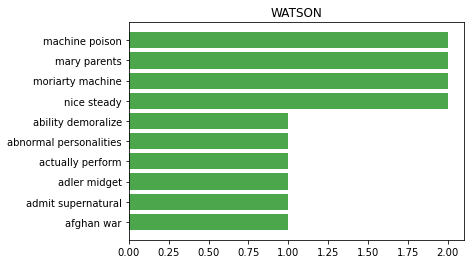

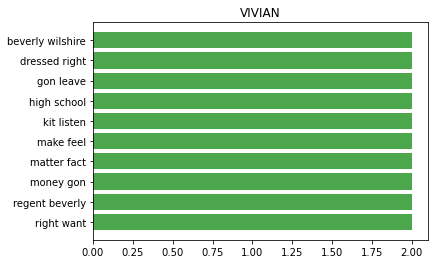

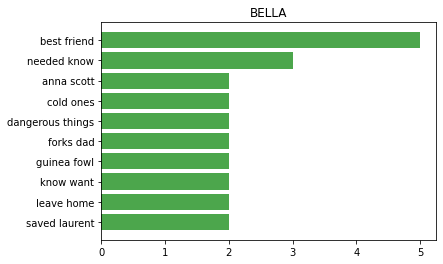

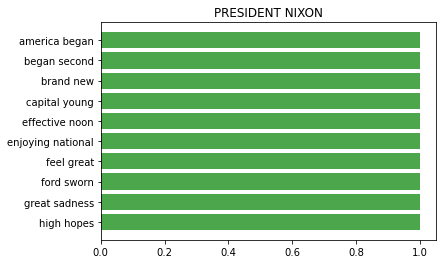

In [87]:
for k,v in bigrams_by_character_top10.items():
    counts = [t[1] for t in v[::-1]]
    bg = [t[0] for t in v[::-1]]
    plt.barh(bg, counts, color = 'g', alpha = 0.7)
    plt.title(k)
    plt.show()

### Adjectivial phrases

How do characters describe nouns? What adjectives do they use? 

In [90]:
dict_dep_count = defaultdict(int)

for text in documents_raw:
    for word in nlp(text):
        if word.dep_ == 'amod':
            dict_dep_count[(word.text, word.head.text)] += 1

k = [' '.join(w) for w in list(dict_dep_count.keys())]
k[:5]

['hiss steam',
 'great criminals',
 'Afghan war',
 'medical practice',
 'nice life']

In [91]:
amods_df = pd.DataFrame({'count': dict_dep_count.values()}, index=k)
amods_df = amods_df.sort_values('count', ascending=False).reset_index().rename({'index':'pair'}, axis=1)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

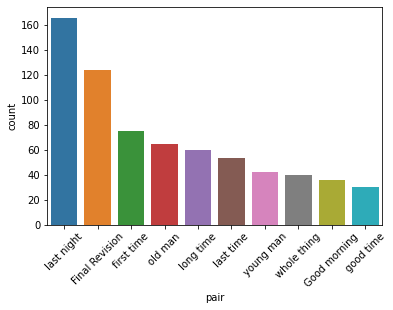

In [97]:
sns.barplot(amods_df.iloc[:10,0], amods_df.iloc[:10,1])
plt.xticks(rotation=45)

Again, not all of them seem to belong to characters' speeches, so in further cleaning we'll get rid of these words.

Which are the rarest noun+adj pairs?

In [98]:
print(amods_df.iloc[-10:,0])

30374                rich motive
30375         marital infidelity
30376                 void event
30377                  null void
30378                  firm fuck
30379       prenuptial agreement
30380               great reason
30381    supervised stepdaughter
30382                Careful men
30383               rite passage
Name: pair, dtype: object


Okay some swearing here, sorry.

## Topic modeling

### Prepare data

To better prepare data for topic modeling, we will filter some most common words from our corpus.

In [99]:
# create a list of most common words to filter them for topic modeling 

cv = CountVectorizer(min_df=0.02, max_df=1.0, ngram_range = (1,1), analyzer = 'word', 
                     stop_words='english') # parameters were fine-tuned
X = cv.fit_transform(documents)
totals = X.sum(axis=0).A1
c = Counter(dict(zip(cv.get_feature_names(), totals)))
common_words = [k for (k,v) in c.most_common(50)] 

In [101]:
tokens_for_topics = [[w for w in sentence if w not in common_words] for sentence in tokens]
len(tokens_for_topics)

41442

Next, we create a dictionary with all tokens and their number of occurances in the documents.

In [102]:
phrases = Phrases(tokens_for_topics, min_count=3, threshold=1)
tokens_colloc = phrases[tokens_for_topics]
dictionary = Dictionary(tokens_colloc)
dictionary.filter_extremes(no_below=15, no_above=0.001)
print(dictionary, flush=True)

Dictionary(1498 unique tokens: ['capital', 'criminal', 'empire', 'existence', 'medical']...)


In [103]:
ldacorpus = [dictionary.doc2bow(text) for text in tokens_for_topics] # this we'll feed to Author model
tfidfmodel = TfidfModel(ldacorpus)
model_corpus = tfidfmodel[ldacorpus] # Tfidf representation will be fed to LDA model

In [104]:
bow_doc_1 = ldacorpus[1]
for i in range(len(bow_doc_1)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_1[i][0], 
                                                     dictionary[bow_doc_1[i][0]], 
                                                     bow_doc_1[i][1]))

Word 3 ("existence") appears 1 time.
Word 4 ("medical") appears 1 time.
Word 5 ("practice") appears 1 time.
Word 6 ("steady") appears 2 time.


### Define classes

In [105]:
class Topic_choice:
    
    def __init__(self):
        
        self.coherence_values = []
        self.descriptors = []
        self.dictionary = None
        self.lda_corpus = None
        self.topic_corpus = None
        self.target_category = 'movie'
        self.author_model_list = []
        self.model_name = ''
        self.author2doc = None
        self.author_corpus = None

    def LDA_topic_num_score(self, lda_corpus, min_num, max_num, instances, dictionary, limit=None):
        """
        Print coherence score of LDA for each number of topics
        Parameters:
            - model_corpus
            - minimun number of topics
            - maximum number of topics
            - instances
            - dictionary
        """
        if limit is None:
            limit = len(instances)//10
        self.lda_corpus = lda_corpus
        self.dictionary = dictionary
        self.coherence_values = []
        self.model_name = 'LdaMulticore'
        
        for num_topics in range(min_num, max_num+1):

            model = LdaMulticore(corpus=lda_corpus[:limit], 
                         id2word=dictionary, 
                         num_topics=num_topics, 
                         random_state=5)

            coherencemodel_umass = CoherenceModel(model=model, 
                                                  texts=instances[:limit], 
                                                  dictionary=dictionary, 
                                                  coherence='u_mass')

            coherencemodel_cv = CoherenceModel(model=model, 
                                               texts=instances[:limit], 
                                               dictionary=dictionary, 
                                               coherence='c_v')

            umass_score = coherencemodel_umass.get_coherence()
            cv_score = coherencemodel_cv.get_coherence()

            print(num_topics, umass_score, cv_score)
            self.coherence_values.append((num_topics, umass_score, cv_score))
    
    def Author_topic_num_score(self, author_corpus, min_num, max_num, instances, dictionary, limit=None):
        """
        Print coherence score of Author Topic Model for each number of topics
        Parameters:
            - author_corpus
            - minimun number of topics
            - maximum number of topics
            - instances
            - dictionary
            - limit (default to len(author_corpus))
        """
        
        self.author_corpus = author_corpus
        self.dictionary = dictionary
        self.coherence_values = []
        self.model_name =  'AuthorTopicModel'
        
        if limit is None:
            limit = len(instances)//10
        
        author2doc = defaultdict(list) 
        for i, movie in enumerate(all_scripts_cleaned[self.target_category][:limit]):
            author2doc[movie].append(i)
            
        dev_author2doc = {key: [idx for idx in value if idx < limit] for key, value in author2doc.items()}
        
        for num_topics in range(min_num, max_num+1):
            
            author_model = AuthorTopicModel(corpus=author_corpus[:limit], 
                                            author2doc=dev_author2doc, 
                                            id2word=dictionary,
                                            alpha=0.5,
                                            num_topics=num_topics,
                                            random_state=23
                                           )

            coherencemodel_umass = CoherenceModel(model=author_model, 
                                                  texts=instances[:limit], 
                                                  dictionary=dictionary, 
                                                  coherence='u_mass')

            coherencemodel_cv = CoherenceModel(model=author_model, 
                                               texts=instances[:limit], 
                                               dictionary=dictionary, 
                                               coherence='c_v')

            umass_score = coherencemodel_umass.get_coherence()
            cv_score = coherencemodel_cv.get_coherence()

            print(num_topics, umass_score, cv_score)
            self.coherence_values.append((num_topics, umass_score, cv_score))

    def plot_coherence(self, coherence_values=None):
        """
        Plot coherence score for each number of topics. 
        Parameters: coherence_values. 
        """
        if coherence_values is None:
            coherence_values = self.coherence_values
            
        scores = pd.DataFrame(self.coherence_values, columns=['num_topics', 'UMass', 'CV'])
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
        scores.plot.line(x='num_topics', y='UMass', ax=ax[0], xticks=np.array(scores.num_topics))
        scores.plot.line(x='num_topics', y='CV', ax=ax[1], xticks=np.array(scores.num_topics))

In [115]:
class Topic_model(Topic_choice):

    def __init__(self, **kwargs):
        
        super().__init__(**kwargs)
        self.movies = 'Harry-Potter-and-the-Goblet-of-Fire Sherlock-Holmes Godfather Titanic Liar-Liar'.split()
        self.genres = None
        self.target_category = 'movie'
        self.topic_num = 6
        self.model = None
        self.author_descriptors = []
        self.model_name = ''
        self.author_vecs = []
        
    def fit_LDA(self, lda_corpus=None, num_topics=None, dictionary=None):
        """
        Fit LDA to a given corpus.
        Parameters:
            - model_corpus
            - num_topics (default is 6)
            - dictionary
        """
        if lda_corpus is None:
            lda_corpus = self.lda_corpus
        else:
            self.lda_corpus = lda_corpus
        if num_topics is None:
            num_topics = self.topic_num
        else:
            self.topic_num = num_topics
        if dictionary is None:
            dictionary = self.dictionary
        else:
            self.dictionary = dictionary
            
        num_passes = 10
        chunk_size = len(lda_corpus) * num_passes/200
        
        self.model = LdaMulticore(num_topics=num_topics, 
                             corpus=lda_corpus, 
                             id2word=dictionary, 
                             workers=min(10, multiprocessing.cpu_count()-1),
                             passes=num_passes, 
                             chunksize=chunk_size,
                             alpha=0.5,
                             random_state=23
                            )
        self.topic_corpus = self.model[lda_corpus]
        self.model_name = 'LDA'
        
    def fit_AuthorTopicModel(self, author_corpus=None, num_topics=None, dictionary=None):
        """
        Fit AuthorTopicModel to a given corpus.
        Parameters:
            - author_corpus
            - num_topics (default is 6)
            - dictionary
        """
        if author_corpus is None:
            author_corpus = self.author_corpus
        else: 
            self.author_corpus = author_corpus
        if num_topics is None:
            num_topics = self.topic_num
        else:
            self.topic_num = num_topics
        if dictionary is None:
            dictionary = self.dictionary
        else:
            self.dictionary = dictionary
            
        if self.author2doc is None:
            author2doc = defaultdict(list) 
            for i, movie in enumerate(all_scripts_cleaned[self.target_category]):
                author2doc[movie].append(i)
        else:
            author2doc = self.author2doc

        num_passes = 10
        chunk_size = len(author_corpus) * num_passes/200

        self.model = AuthorTopicModel(corpus=author_corpus, 
                                        author2doc=author2doc, 
                                        id2word=dictionary, 
                                        num_topics=num_topics,
                                        passes=num_passes,
                                        chunksize=chunk_size,
                                        alpha=0.5,
                                        random_state=23
        )
        self.model_name = 'ATM'
        
    def topic_description(self):
        """
        Print most infomartive words for each topic
        """
        topic_sep = re.compile("0\.[0-9]{3}\*")
        model_topics = [(topic_no, re.sub(topic_sep, '', model_topic).split(' + ')) 
                        for topic_no, model_topic in
                        self.model.print_topics(num_topics=self.topic_num, num_words=10)]
        self.descriptors = []
        for i, m in sorted(model_topics):
            print(i+1, ", ".join(m[:10]))
            self.descriptors.append(", ".join(m[:3]).replace('"', '')) # this is different 

    def plot_topics_distribution(self, movies=None, limit=None, topic_corpus=None):
        """
        Plot the distribution of topics across movies.
        Parameters:
            - movies: list of movies for x-axis
            - limit: limit the number of documents to speed up
            - topic_corpus: documents in doc2bow 
        """
        if movies is None:
            movies = self.movies

        if self.model_name == 'LDA':
            if limit is None:
                limit = len(self.topic_corpus)
            if topic_corpus is None:
                topic_corpus = self.topic_corpus            
            scores = [[t[1] for t in self.topic_corpus[entry]] for entry in range(limit)]
            topic_distros = pd.DataFrame(data=scores, columns=self.descriptors)
            topic_distros['category'] = all_scripts_cleaned[self.target_category][:limit]

            aggregate_by_category = topic_distros[topic_distros.category.isin(movies)]
            aggregate_by_category = aggregate_by_category.groupby(aggregate_by_category.category).mean()

            fig, ax = plt.subplots(figsize=(12, 6))
            aggregate_by_category[self.descriptors].plot.bar(ax=ax, alpha=0.9)
            plt.title(self.model_name + ' topic destribution', size=16)
            plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize=16)
            plt.xticks(rotation=45, size = 16)
            plt.yticks(size = 16)
        
        if self.model_name == 'ATM':

            author_vecs = {author: {self.descriptors[t]: 0.0
                                     for t in range(self.model.num_topics)}
                          for author in self.model.id2author.values()
                          }
            for author in self.model.id2author.values():
                for (t, v) in self.model.get_author_topics(author):
                    author_vecs[author][self.descriptors[t]] = v
            self.author_vecs = author_vecs
            author_df = pd.DataFrame.from_dict(author_vecs)
            fig, ax = plt.subplots(figsize=(12,6))
            author_df[movies].T.plot.bar(ax=ax, alpha=0.9)
            plt.title('Topic destribution with author topic modeling', size=20)
            plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize=16);
            plt.xticks(rotation=45, size = 14)
            plt.yticks(size = 14)

### Try out

First we'll try find an optimal number of topics with LDA model using coherence scores.

In [107]:
cp = Topic_choice()
cp.LDA_topic_num_score(lda_corpus=model_corpus, min_num=6, max_num=12, instances=tokens_for_topics, 
                       dictionary=dictionary)

6 -21.12222516530763 0.8286912525461259
7 -20.96750683028324 0.8195525285921461
8 -21.05937503578179 0.8246981522366786
9 -20.93700950818196 0.8185517687315159
10 -20.98771539348121 0.821525235430561
11 -20.883469962514756 0.8194304669701702
12 -20.98945495847693 0.8224980329365943


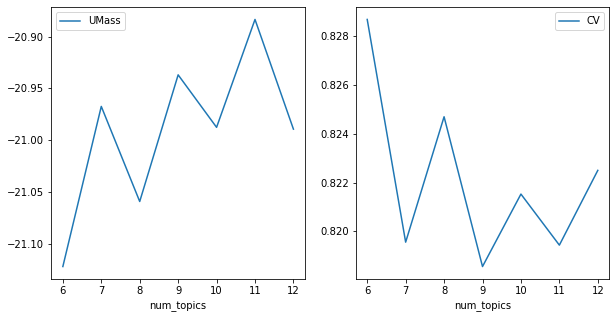

In [108]:
cp.plot_coherence() 

6 topics seem to be fine.

In [111]:
tm = Topic_model()
%time tm.fit_LDA(lda_corpus = ldacorpus, num_topics=6, dictionary=dictionary)

CPU times: user 9.66 s, sys: 2.88 s, total: 12.5 s
Wall time: 26.4 s


In [112]:
tm.topic_description()

1 "madam", "horror", "safety", "governor", "hunt", "chair", "shotgun", "swing", "bottle", "cloud"
2 "diner", "innocent", "radio", "witch", "sidney", "lean", "bontecou", "shift", "thou", "wave"
3 "chamber", "devil", "rip", "baron", "shield", "angels", "loose", "holy", "lion", "react"
4 "drunk", "exchange", "tooth", "flip", "relationship", "respond", "shape", "whip", "nature", "bus"
5 "half", "prince", "counter", "harry", "scene", "favorite", "proof", "patient", "droid", "receive"
6 "howard", "too", "print", "note", "sing", "suck", "percy", "focus", "fat", "south"


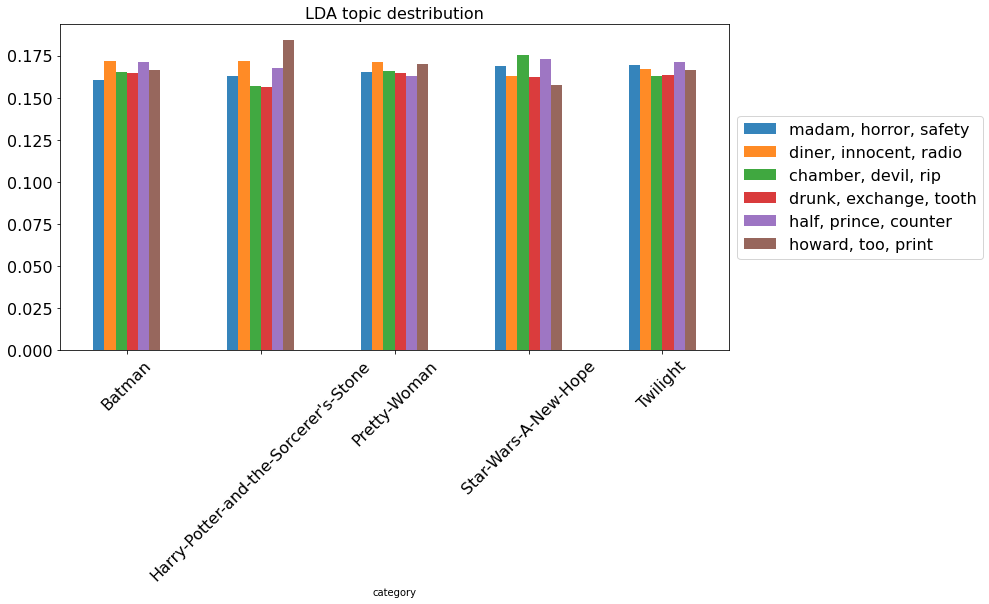

In [113]:
tm.plot_topics_distribution(movies = ["Harry-Potter-and-the-Sorcerer's-Stone", 'Batman', 'Star-Wars-A-New-Hope',
                             'Pretty-Woman', 'Twilight'])

Looks like all topics are equally distributed across movies. 

Let's try Author topic modeling.

In [116]:
tm = Topic_model()
%time tm.fit_AuthorTopicModel(author_corpus=ldacorpus, num_topics=6, dictionary=dictionary)

CPU times: user 1min 32s, sys: 884 ms, total: 1min 33s
Wall time: 1min 36s


In [117]:
tm.topic_description()

1 "thou", "droid", "exchange", "hunt", "ill", "shotgun", "east", "stu", "shape", "annie"
2 "half", "madam", "grusinskaya", "vatican", "radio", "blast", "innocent", "merger", "bottle", "wave"
3 "diner", "baron", "chamber", "shield", "lion", "luke", "holy", "safety", "horror", "shift"
4 "harry", "riddle", "vick", "patient", "empire", "bontecou", "sidney", "chastity", "committee", "loud"
5 "witch", "art", "drunk", "favorite", "governor", "slytherin", "rip", "scene", "mama", "cell"
6 "prince", "too", "counter", "wicked", "diary", "howard", "sing", "note", "unit", "angel"


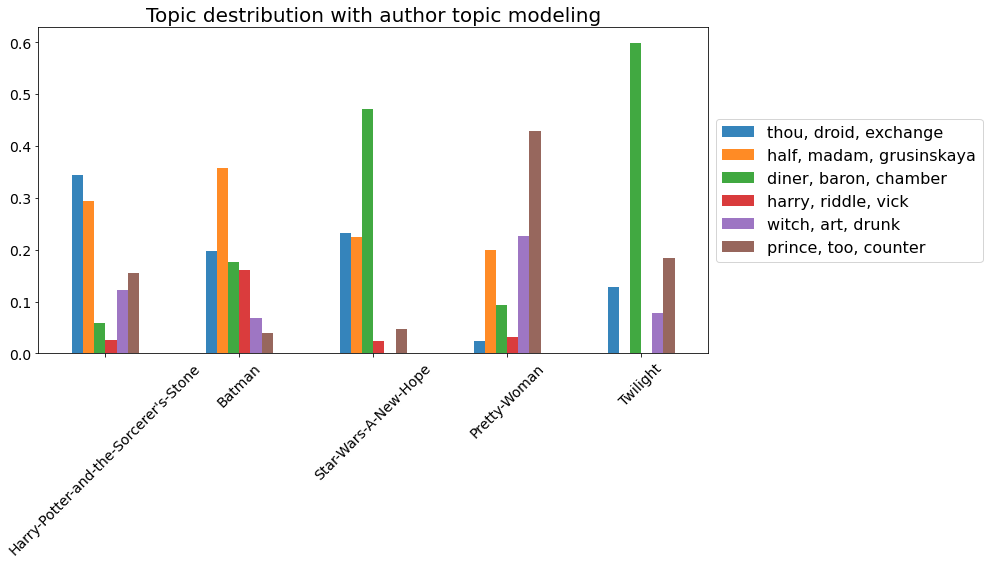

In [118]:
tm.plot_topics_distribution(["Harry-Potter-and-the-Sorcerer's-Stone", 'Batman', 'Star-Wars-A-New-Hope',
                             'Pretty-Woman', 'Twilight'])

## Clustering

### Define functions

In [119]:
sns.set_context('notebook')

def plot_vectors(vectors, title='VIZ', labels=None, dimensions=3):
    """
    plot the vectors in 2 or 3 dimensions. 
    If labels are supplied, use them to color the data accordingly
    """
    fig = plt.figure(figsize=(6,6))

    df = pd.DataFrame(data={'x':vectors[:,0], 'y': vectors[:,1]})

    if labels is not None:
        df['label'] = labels.values
    else:
        df['label'] = [''] * len(df)

    cm = plt.get_cmap('spring') 
    n_labels = len(df.label.unique())
    label_colors = [cm(1. * i/n_labels) for i in range(n_labels)]
    cMap = colors.ListedColormap(label_colors)
        
    if dimensions == 3:
        df['z'] = vectors[:,2]
        ax = fig.add_subplot(111, projection='3d')
        frame1 = plt.gca() 
        frame1.axes.xaxis.set_ticklabels([])
        frame1.axes.yaxis.set_ticklabels([])
        frame1.axes.zaxis.set_ticklabels([])

        for l, label in enumerate(df.label.unique()):
            df2 = df[df.label == label]
            color_values = [label_colors[l]] * len(df2)
            ax.scatter(df2['x'], df2['y'], df2['z'], 
                       c=color_values, 
                       cmap=cMap, 
                       edgecolor='black', 
                       label=label, 
                       alpha=0.4, 
                       s=100)
      
    elif dimensions == 2:
        ax = fig.add_subplot(111)
        frame1 = plt.gca()

        for l, label in enumerate(df.label.unique()):
            df2 = df[df.label == label]
            color_values = [label_colors[l]] * len(df2)
            ax.scatter(df2['x'], df2['y'], 
                       c=color_values, 
                       cmap=cMap, 
                       edgecolor='black', 
                       label=label, 
                       alpha=0.4, 
                       s=100)

    else:
        raise NotImplementedError()
    
    plt.title(title)
    plt.legend()
    plt.show()

def show_topics(A, vocabulary, topn=10):
    """
    find the top N words for each of the latent dimensions (=rows) in a matrix
    """
    topic_words = ([[vocabulary[i] for i in np.argsort(t)[:-topn-1:-1]]
                    for t in A])
    return [', '.join(t) for t in topic_words]

### Latent dimentions

It would be great to have more upper-level view on the movies for vizualization purposes, so genres could serve as a nice aggregation. However, the original dataset came without genre annotation, so I manually added genre for each movie refering to the well-known [IMDB](www.imdb.com/).

In [120]:
movies_genre = pd.read_excel('movies.xlsx').drop('Unnamed: 0', axis=1)
movies_genre.rename({'movies':'movie', 'Unnamed: 2':'genre'}, axis=1, inplace=True)
movies_genre.head(2)

,movie,genre
0,Harry-Potter-and-the-Prisoner-of-Azkaban,Adventure
1,"Postman,-The",Action


In [122]:
text_by_genre = pd.merge(movies_genre, all_scripts_cleaned, on='movie')[['movie', 'genre','script_no_names_cleaned']]
arr = np.arange(len(text_by_genre))
out = np.random.permutation(arr) # shuffle data
text_by_genre = text_by_genre.loc[out]
print(text_by_genre.shape)
text_by_genre.head(2)

(41442, 3)


,movie,genre,script_no_names_cleaned
22593,"Happy-Birthday,-Wanda-June",Comedy,think apartment seem home
40450,Lord-of-the-Rings-The-Two-Towers,Adventure,wonder people ever say hear Ring. theyll say...


In [123]:
text_by_genre.genre.value_counts()

Adventure    9785
Action       8817
Drama        7556
Romance      5104
Comedy       4921
Horror       2631
Crime        2628
Name: genre, dtype: int64

I'll go further with scripts cleaning, because I want to filter the most common words which are non-informative and also filter some specific stopwords which I defined after running the algorithm multiple times. 

In [125]:
text_by_genre['script_no_names_cleaned'] = text_by_genre.script_no_names_cleaned.apply(str).apply(lambda x: ' '.join([token.text for token in nlp(x) 
                                                       if token.text not in common_words]))
docs_for_ld = text_by_genre['script_no_names_cleaned'].tolist()
docs_for_ld = pd.Series(docs_for_ld).apply(lambda x: re.sub(r'[-.?!,":/\;()|0-9]', '', x)).tolist()

# this is very slow
my_stopwords = 'october continued final mr revision charlie half blood prince harry potter rev angels out\x97it'.split()
docs_for_ld = [[token.text.lower() for token in nlp(sentence) if token.text.lower() not in my_stopwords] for sentence in docs_for_ld]
docs_for_ld = pd.Series(docs_for_ld).apply(lambda x: ' '.join([w for w in x])).tolist()

In [127]:
text_by_genre.head()

,movie,genre,script_no_names_cleaned
22593,"Happy-Birthday,-Wanda-June",Comedy,apartment seem home
40450,Lord-of-the-Rings-The-Two-Towers,Adventure,wonder people ever hear Ring. theyll yes fa...
27378,Fight-Club,Drama,Tyler set franchise country
16015,"English-Patient,-The",Romance,different world different life different wife
933,"Postman,-The",Action,God Ford people die


Now let's try to find latent dimensions (or topics) by first creating a matrix of vectors for bigrams.

In [128]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(2,2), 
                                   stop_words=stopwords_, 
                                   analyzer='word', 
                                   min_df=0.0001, # this was tuned by many trials
                                   max_df=0.2,  
                                   sublinear_tf=True, 
                                   use_idf=True) 

X = tfidf_vectorizer.fit_transform(docs_for_ld)

print(X.shape)

(41442, 2145)


In [129]:
df = pd.DataFrame(data={'word': tfidf_vectorizer.get_feature_names(), 
                        'tf': X.sum(axis=0).A1, 
                        'idf': tfidf_vectorizer.idf_,
                        'tfidf': X.sum(axis=0).A1
                   }).sort_values(['tfidf', 'tf', 'idf'])
df.head(3)

,word,tf,idf,tfidf
1182,love woman,2.747666,9.840315,2.747666
1420,people hate,2.763769,9.840315,2.763769
1990,turn dark,2.772039,9.840315,2.772039


I am setting the number of latent components to 7 as there are 7 genres in our dataset.

In [130]:
k = 7

svd = TruncatedSVD(n_components=k)
%time U = svd.fit_transform(X)
S = svd.singular_values_
V = svd.components_

print(U.shape, S.shape, V.shape)

CPU times: user 243 ms, sys: 49.5 ms, total: 293 ms
Wall time: 170 ms
(41442, 7) (7,) (7, 2145)


In [131]:
nmf = NMF(n_components=k, init='nndsvd', random_state=0)

%time W = nmf.fit_transform(X)
H = nmf.components_
print(W.shape, H.shape)

CPU times: user 776 ms, sys: 108 ms, total: 884 ms
Wall time: 572 ms
(41442, 7) (7, 2145)


In [132]:
terms = tfidf_vectorizer.get_feature_names()
show_topics(V, terms)

['get back, take care, get get, try get, well get, get away, back back, fine get, care kid, back house',
 'take care, care kid, get take, ever see, nice meet, old lady, love much, wait get, never take, well take',
 'devil advocate, last night, old friend, go get, god sake, harvey dent, god damn, obi wan, ever hear, never hear',
 'get get, get away, get outta, get move, get ready, try get, get call, go get, get work, jesus christ',
 'new york, york city, back new, get new, save life, never hear, feel well, ever hear, great distance, work new',
 'shake head, never see, ever hear, close eye, get away, go back, chim chim, obi wan, try keep, bring back',
 'get away, go get, last night, one get, go back, try get, hope get, away get, old friend, never get']

In [133]:
show_topics(H, terms)

['get back, try get, well get, back back, back house, fine get, back get, back sleep, see get, back work',
 'take care, care kid, get take, ever see, nice meet, old lady, wait get, love much, well take, never take',
 'devil advocate, go get, go back, old friend, open door, save life, get well, get go, get kill, get lot',
 'get get, get outta, get move, get ready, try get, get call, jesus christ, fine get, get work, back work',
 'new york, york city, back new, get new, ever hear, great distance, work new, take new, police officer, go first',
 'shake head, ever hear, try keep, chim chim, really get, dear boy, step away, mrs cole, one else, door close',
 'get away, go get, try get, never get, one get, hope get, away get, gotham city, give moment, ever get']

Topic 1: movement, going somewhere <br /> 
Topic 2: taking care <br /> 
Topic 3: looks like an action movie<br /> 
Topic 4: arguing, yieling <br /> 
Topic 5: work, business <br /> 
Topic 6: mistery <br /> 
Topic 7: this one I have no clue :D

In [134]:
low_dim_svd = TruncatedSVD(n_components=3)
low_dim_nmf = NMF(n_components=3, init='nndsvd')

num_plot = 200
Z = X[:num_plot]
categories = text_by_genre.genre[:num_plot]

low_dim_U = low_dim_svd.fit_transform(Z)
low_dim_W = low_dim_nmf.fit_transform(Z)

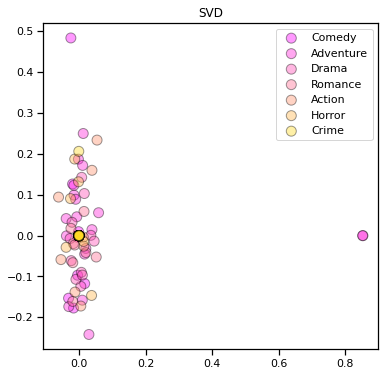

In [135]:
plot_vectors(low_dim_U, title='SVD', labels=categories, dimensions=2)

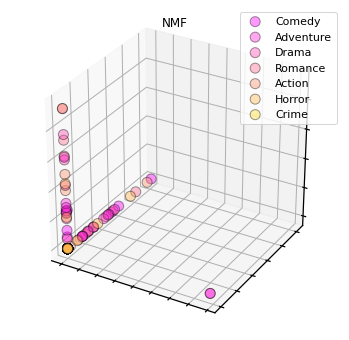

In [136]:
plot_vectors(low_dim_W, title='NMF', labels=categories, dimensions=3)

Now let's try to do the same but using both unigrams and bigrams.

In [137]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), 
                                   stop_words=stopwords_, 
                                   analyzer='word', 
                                   min_df=0.0005, # this was tuned by many trials
                                   max_df=0.2,  
                                   sublinear_tf=True, 
                                   use_idf=True) 

X = tfidf_vectorizer.fit_transform(docs_for_ld)

print(X.shape)

(41442, 1872)


In [138]:
k = 7

svd = TruncatedSVD(n_components=k)
%time U = svd.fit_transform(X)
S = svd.singular_values_
V = svd.components_

print(U.shape, S.shape, V.shape)

CPU times: user 284 ms, sys: 44.8 ms, total: 329 ms
Wall time: 168 ms
(41442, 7) (7,) (7, 1872)


In [139]:
nmf = NMF(n_components=k, init='nndsvd', random_state=0)

%time W = nmf.fit_transform(X)
H = nmf.components_
print(W.shape, H.shape)

CPU times: user 952 ms, sys: 96.1 ms, total: 1.05 s
Wall time: 491 ms
(41442, 7) (7, 1872)


In [140]:
terms = tfidf_vectorizer.get_feature_names()
show_topics(V, terms)

['get, go, see, back, take, well, never, find, get get, talk',
 'see, go, take, back, never, well, give, find, really, talk',
 'go, back, go get, help, talk, kill, go back, try, stay, keep',
 'take, back, give, care, find, take care, call, really, like, help',
 'back, give, call, talk, love, never, find, really, much, thank',
 'back, take, see, go, get back, go back, get, bring back, turn back, call back',
 'call, give, talk, wait, work, phone, ask, police, name, gon']

In [141]:
show_topics(H, terms)

['get, get get, get back, away, get away, go get, listen, try get, gon, gon get',
 'see, never see, eye, see see, ever see, see get, face, never, ever, turn',
 'go, go get, go back, home, stay, keep, away, go go, hell, kill',
 'take, care, take care, home, place, long, easy, away, hand, go take',
 'never, give, find, well, talk, love, really, like, much, work',
 'back, get back, turn, go back, give, bring, put, door, head, bring back',
 'call, gon, phone, police, call back, mother, name, ask, phone call, get call']

More difficult to infer topics here, but still we can notice similar patterns! <br />

Topic 1: movement, going somewhere <br /> 
Topic 4: taking care <br /> 


In [142]:
low_dim_svd = TruncatedSVD(n_components=3)
low_dim_nmf = NMF(n_components=3, init='nndsvd')

num_plot = 300
Z = X[:num_plot]
categories = text_by_genre.genre[:num_plot]

low_dim_U = low_dim_svd.fit_transform(Z)
low_dim_W = low_dim_nmf.fit_transform(Z)

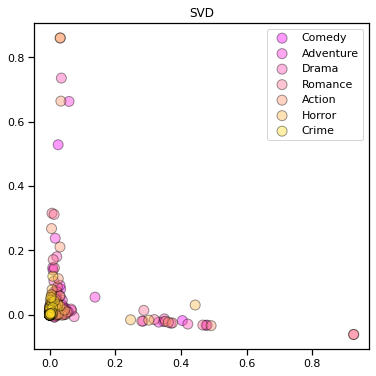

In [143]:
plot_vectors(low_dim_U, title='SVD', labels=categories, dimensions=2)

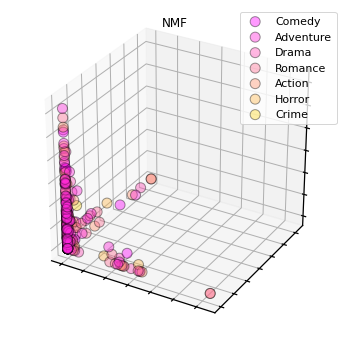

In [144]:
plot_vectors(low_dim_W, title='NMF', labels=categories, dimensions=3)

### K-means clustering

Let's find out what is the best number of clusters for our data with agglomerative clustering.

5 0.05795221831872405
6 0.054604618083363934
7 0.04274780961150923
8 0.04222711475940705
9 0.04162365191136129


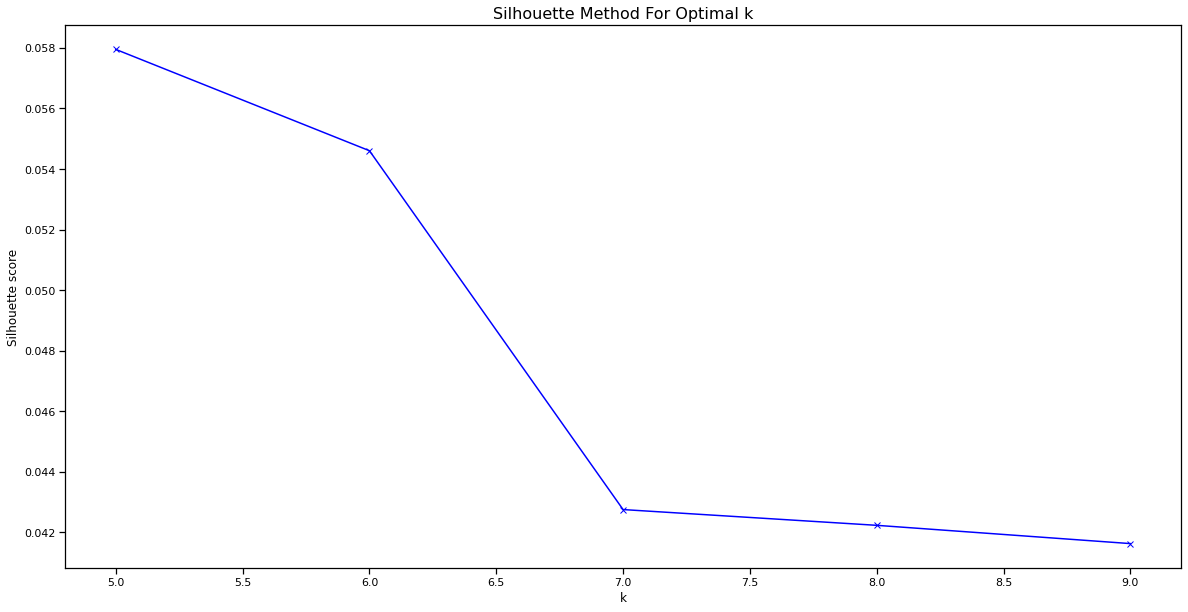

In [146]:
X2 = TruncatedSVD(n_components=500).fit_transform(X)
sample = np.random.choice(len(X2), replace=False, size=10000)

silhouettes = []
K = range(5, 10)

for c in K:
    agg_clustering = AgglomerativeClustering(n_clusters=c)
    agg_cluster_ids = agg_clustering.fit_predict(X2[sample])
    score = silhouette_score(X2[sample], agg_cluster_ids)
    silhouettes.append(score)
    print(c, score)
    
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(K, silhouettes, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.title('Silhouette Method For Optimal k', size = 16)
plt.show()

5 seems to be the right number to go.

In [147]:
k = 5

agg = AgglomerativeClustering(n_clusters=k)
agg_sample_ids = agg.fit_predict(X2[sample])
centroids = np.array([X2[sample][agg_sample_ids == c].mean(axis=0) for c in range(k)])
km = KMeans(n_clusters=k, 
            n_jobs=-1, 
            init=centroids)

km.fit(X2)

KMeans(init=array([[ 5.14507889e-02,  3.89827799e-02,  2.50229005e-03, ...,
        -1.20217089e-04,  4.01223688e-04,  1.51222032e-04],
       [ 7.25344291e-01, -2.84310674e-01, -1.71924134e-02, ...,
        -1.22716500e-03, -1.56337279e-03,  1.14587819e-03],
       [ 8.54100504e-04,  1.19899581e-03,  5.05274307e-04, ...,
         5.63174182e-04,  1.38473141e-03, -6.98527965e-04],
       [ 3.43144773e-02,  7.06173781e-02,  4.33692884e-03, ...,
        -1.29102779e-03,  9.07260380e-04,  1.32359016e-04],
       [ 1.43034624e-01,  3.72101991e-01, -4.21437810e-01, ...,
        -3.92196978e-03, -4.45708032e-03, -6.18713171e-03]]),
       n_clusters=5, n_jobs=-1)

In [184]:
pd.Series(km.labels_).value_counts()

0    35502
1     3431
4     2001
3      433
2       75
dtype: int64

Let's vizualize the results and see how well the clusters are separated in space.

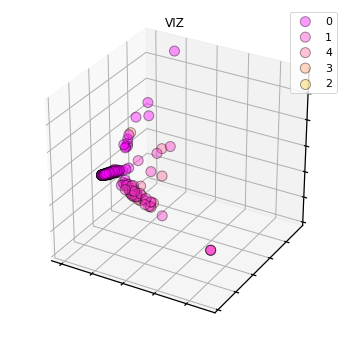

In [148]:
plot_sample = np.random.choice(len(X2), replace=False, size=300)
plot_vectors(X2[plot_sample], labels=pd.Series(km.labels_[plot_sample]))

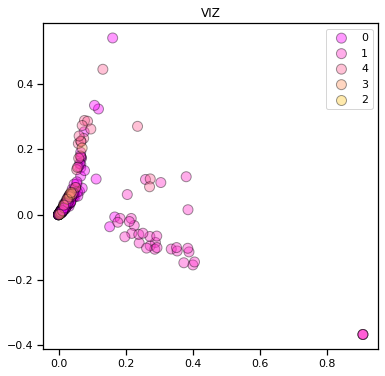

In [149]:
plot_vectors(X2[plot_sample], labels=pd.Series(km.labels_[plot_sample]), dimensions=2)

In fact, most documents belong to one cluster, and we see two other smaller clusters like brunches going from the center.

## Continious representation

### Define functions

In [5]:
def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, a, filename=None):
    plt.figure(figsize=(8, 6))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=np.array([color]), alpha=a, label=label, s=80)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.8, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=14)
    plt.legend(loc=4)
    plt.title(title, size=16)
#     plt.grid(True)
    plt.show()


### Word2Vec

In [185]:
w2v_model = Word2Vec(size=300, 
                     window=7, 
                     sample=0.0001, 
                     iter = 1000, 
                     negative=5,
                     min_count=5, 
                     workers=-1,
                     sg = 0,
                     hs=0, seed = 21
)

w2v_model.build_vocab(tokens_for_topics)

%time w2v_model.train(tokens_for_topics, \
                      total_examples=w2v_model.corpus_count, \
                      epochs=w2v_model.epochs)

keys = ['love', 'kill', 'witch', 'safety']

for word in keys:
    print(word, ': ', [w[0] for w in w2v_model.wv.most_similar(word)[:7]], '\n')

CPU times: user 35.7 s, sys: 754 ms, total: 36.5 s
Wall time: 37.3 s
love :  ['flashlight', 'whip', 'mop', 'softly', 'portal', 'inquire', 'stairwell'] 

kill :  ['servant', 'photographer', 'over-', 'beauty', 'blame', 'stiffen', 'whisper'] 

witch :  ['casino', 'rich', 'definitely', 'property', 'primary', 'someplace', 'ashe'] 

safety :  ['balance', 'ragged', 'turner', 'elephant', 'begin', 'mommy', 'filch'] 



Actually, this makes sense :D

In [186]:
embedding_clusters = []
word_clusters = []

for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in w2v_model.most_similar(word, topn=7):
        words.append(similar_word)
        embeddings.append(w2v_model[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=6, n_components=2, init='pca', n_iter=500, random_state=23)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

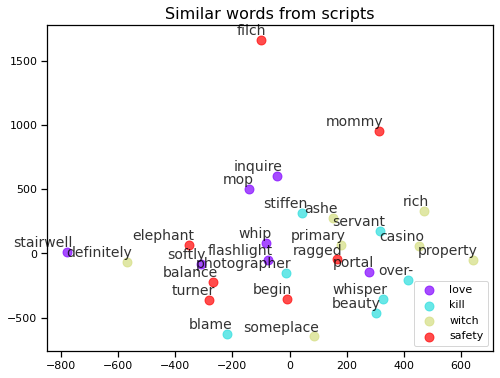

In [187]:
tsne_plot_similar_words('Similar words from scripts', keys, embeddings_en_2d, word_clusters, 0.7)

Words similar to given keywords are in general different from each other. However, we can see that 'beauty' is close to 'whisper' and 'casino', 'rich' and 'property' also close to each other because they are likely to appear in the same context.

### Doc2Vec

Let's see which characters are similar to each other. <br />

I first shuffle the documents so that we could get a representative sample in case we want to use the subset of data.

In [158]:
arr = np.arange(len(all_scripts_cleaned))
out = np.random.permutation(arr) 
df_doc2vec = all_scripts_cleaned.loc[out]

In [160]:
corpus = []

for label, text in zip(df_doc2vec.character, df_doc2vec.script_no_names_cleaned.apply(str)):
    corpus.append(TaggedDocument(words=text.split(), 
                                 tags=[str(label)]))

d2v_model = Doc2Vec(vector_size=400, 
                    window=10, # tuned after iterations 
                    hs=0,
                    sample=0.000001,
                    negative=5,
                    min_count=5,
                    workers=-1,
                    epochs=500,
                    dm=1, # distributed bag of words-0, distributed memory-1
                    dbow_words=1) # trains word-vectors

# build the vocabulary
d2v_model.build_vocab(corpus)

# train the model
%time d2v_model.train(corpus, total_examples=d2v_model.corpus_count, epochs=d2v_model.epochs)

CPU times: user 20.7 s, sys: 426 ms, total: 21.1 s
Wall time: 21.7 s


In [166]:
most_similar = d2v_model.docvecs.most_similar('WATSON', topn=5)
[print(f"{character[0]} from {all_scripts_cleaned[all_scripts_cleaned['character']==character[0]].movie.values[0]}, score {round(character[1],2)}",'\n')
       for character in most_similar]

COLIN from Harry-Potter-and-the-Chamber-of-Secrets, score 0.17 

BETSY from Sense-and-Sensibility, score 0.17 

CHERIE from Queen,-The, score 0.17 

COP #2 from Spider-Man, score 0.14 

WITCHES from Nightmare-Before-Christmas,-The, score 0.14 



[None, None, None, None, None]

The resutls are pretty consistent even changing **window, dm, dbow_words, vector size** parameters.. However, I wouldn't say Watson is similar to Betsy after all.

## Language modeling

Finally, it would be great to generate speech in a style of a particular movie! So here I use the dictionary with all text by movies to calculute trigrams frequencies for each movie.

In [167]:
smoothing = 0.001
START = '_***_'
STOP = '_STOP_'

movies = all_scripts_cleaned.movie.unique().tolist()

counts = {movie : defaultdict(lambda: defaultdict(lambda: smoothing)) for movie in movies}

corpus = {movie: [text.strip().split() for text in text_by_movie[movie]] 
          for movie in movies}

for movie in movies:
    for sentence in corpus[movie]:
        tokens = [START, START] + sentence + [STOP]
        for u, v, w in nltk.ngrams(tokens, 3):
            counts[movie][(u, v)][w] += 1
    
def sample_next_word(u, v, movie):
    """
    sample a word w based on the history (u, v)
    """
    keys, values = zip(*counts[movie][(u, v)].items())
    values = np.array(values)
    values /= values.sum() 
    sample = np.random.multinomial(1, values) 

    return keys[np.argmax(sample)]

def matchingKeys(dictionary, searchString):
    return [key for key,val in dictionary.items() if any(searchString in s for s in key)][0]

def generate(movie, result=''):
    """
    generate text in the style of a particular movie based on the input sentence
    """
    result = [START, START] + result.split()
    try:
        next_word = sample_next_word(result[-2], result[-1], movie)
    except ValueError:
        try:
            new_keys = matchingKeys(counts[movie], result[-1])
            next_word = sample_next_word(new_keys[0], new_keys[1], movie)
        except ValueError:
            next_word = sample_next_word(START, START, movie)
    result.append(next_word)
#     print('added first word: ', next_word)
    while next_word != STOP:
        try:
            next_word = sample_next_word(result[-2], result[-1], movie)
        except ValueError:
#             print(result[-1])
            new_keys = matchingKeys(counts[movie], result[-1])
#             print('new_keys:', new_keys)
            next_word = sample_next_word(new_keys[0], new_keys[1], movie)
        result.append(next_word)
    print(movie, ':', ' '.join(result[2:-1]), '\n')
#     return ' '.join(result[2:-1])

In [174]:
generate("Sherlock-Holmes", "Why would I")
generate("Terminator", "Why would I")
generate("Godfather", "Why would I")
generate("Titanic", "Why would I")

Sherlock-Holmes : Why would I not be invited to my own terms. Just like you -- well, not you at this exact moment -- 

Terminator : Why would I put you on the tube by eleven, she may just call us. How do I know about guerrilla warfare? 

Godfather : Why would I know you're not Catholic. He's in the Drug Rackets...things are starting to loosen up. 

Titanic : Why would I still gets me every time. 



Generating speech of a given character can be even more fun...

In [175]:
characters = all_scripts_cleaned.character.unique().tolist()
         
counts_characters = {character : defaultdict(lambda: defaultdict(lambda: smoothing)) for character in characters}

corpus_characters = {character: [text.strip().split() for text in text_by_character[character]] 
          for character in characters}

for character in characters:
    for sentence in corpus_characters[character]:
        tokens = [START, START] + sentence + [STOP]
        for u, v, w in nltk.ngrams(tokens, 3):
            counts_characters[character][(u, v)][w] += 1
            
def sample_next_word(u, v, character):
    """
    sample a word w based on the history (u, v)
    """
    keys, values = zip(*counts_characters[character][(u, v)].items())
    values = np.array(values)
    values /= values.sum() 
    sample = np.random.multinomial(1, values) 

    return keys[np.argmax(sample)]

def matchingKeys(dictionary, searchString):
    return [key for key,val in dictionary.items() if any(searchString in s for s in key)][0]

def generate(character, result=''):
    """
    generate text in the style of a particular character based on the input sentence
    """
    result = [START, START] + result.split()
    try:
        next_word = sample_next_word(result[-2], result[-1], character)
    except ValueError:
        try:
            new_keys = matchingKeys(counts_characters[character], result[-1])
            next_word = sample_next_word(new_keys[0], new_keys[1], character)
        except ValueError:
            next_word = sample_next_word(START, START, character)
    result.append(next_word)
#     print('added first word: ', next_word)
    while next_word != STOP:
        try:
            next_word = sample_next_word(result[-2], result[-1], character)
        except ValueError:
#             print(result[-1])
            new_keys = matchingKeys(counts_characters[character], result[-1])
#             print('new_keys:', new_keys)
            next_word = sample_next_word(new_keys[0], new_keys[1], character)
        result.append(next_word)
    print(character, ':', ' '.join(result[2:-1]), '\n')
#     return ' '.join(result[2:-1])

In [179]:
generate('WATSON')
generate('BATMAN')
generate('VIVIAN')
generate('BELLA')
generate('PRESIDENT NIXON')

WATSON : Case solved! You're just not her type, Holmes. She likes ginger dwarfs. 

BATMAN : Don't make me kill you in front of the barrel of a gun, Dent. 

VIVIAN : It was so beautiful I just hope it was going to spend money. 

BELLA : Still loves you though. 

PRESIDENT NIXON : So are you enjoying yourself in our national capital, young man? 



Overall, we have learned that there are indeed different topics across movies which we can learn from the scripts. We can also find similar characters and movies, although here the results could have been better if we had more speeches by each character. Clustering results could be improved if movie genres apriory are better represented - in our dataset movies were not equally distributed across genres. 

Further analysis of speeches by characters could be made to then find famous personas in real life who are similar to a given movie hero.It would be also cool to try and guess the character by his/her speech and to analyze how the sentiment or a given character is changing across the movie scenes. 